In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ipywidgets import interact, IntSlider, SelectionSlider

# small high-dimensional dataset
n, p = 40, 120
rng = np.random.default_rng(0)

# predictors
X = rng.normal(size=(n, p))

# true coefficients (only a few nonzero)
beta_true = np.zeros(p)
beta_true[[19, 39, 59, 79, 99, 119]] = [0.25, -0.75, 1, -3.5, 4, -6]

signal = X @ beta_true
target_signal_noise_ratio = 5.0
sigma = np.std(signal) / np.sqrt(target_signal_noise_ratio)
noise = rng.normal(scale=sigma, size=n)

# y = X * beta + noise
# noise = rng.normal(scale=2.0, size=n)
y = signal + noise

# dataframe with predictors + response
df = pd.DataFrame(X, columns=[f"x{j+1}" for j in range(p)])
df["y"] = y

# print(df.shape)
# print(df.head())
print("\nTrue nonzero betas at:", np.nonzero(beta_true)[0] + 1)



True nonzero betas at: [ 20  40  60  80 100 120]


In [2]:
import statsmodels.api as sm

# predictors (all x columns)
X = df.drop(columns="y")

# add intercept
X = sm.add_constant(X)

# responseThi
y = df["y"]

# OLS fit
ols_model = sm.OLS(y, X).fit()

# print(ols_model.summary())
# ols_model.summary()

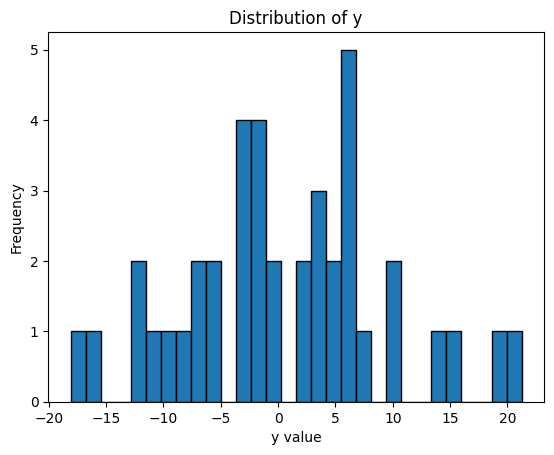

y-min: -18.09
y-max: 21.23
y-mean: 0.48
y-standard deviation: 8.93


In [3]:
plt.hist(y, bins=30, edgecolor="k")
plt.title("Distribution of y")
plt.xlabel("y value")
plt.ylabel("Frequency")
plt.show()
print(f"y-min: {round(y.min(), 2)}")
print(f"y-max: {round(y.max(), 2)}")
print(f"y-mean: {round(y.mean(), 2)}")
print(f"y-standard deviation: {round(y.std(), 2)}")


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lasso = Lasso(alpha=0.1, random_state=0).fit(X_train, y_train)
y_hat = lasso.predict(X_test)

df_coef = pd.DataFrame()
feature_names = ['β0'] + [f"β{j+1}" for j in range(p)]
df_coef['feature'] = feature_names
df_coef['Coefficients'] = lasso.coef_
df_coef['AbsCoef'] = df_coef['Coefficients'].abs()
df_coef[df_coef['Coefficients'] != 0].sort_values(by='AbsCoef', ascending=False)

,feature,Coefficients,AbsCoef
120,β120,-4.771564,4.771564
100,β100,3.224663,3.224663
80,β80,-2.087032,2.087032
26,β26,-0.835026,0.835026
61,β61,-0.816341,0.816341
25,β25,-0.755971,0.755971
47,β47,0.655696,0.655696
7,β7,-0.651612,0.651612
63,β63,-0.575410,0.575410
68,β68,-0.561596,0.561596


In [5]:
mse = mean_squared_error(y_test, y_hat)
mae = mean_absolute_error(y_test, y_hat)
print(f"Mean squared error: {round(mse, 2)}")
print(f"Mean absolute error: {round(mae, 2)}")
print(r2_score(y_test, y_hat))
lasso.score(X_test, y_test)


Mean squared error: 20.79
Mean absolute error: 4.25
0.6831811189488692


0.6831811189488692

In [ ]:
# ---------- 2) Precompute over a small alpha grid (fast & simple) ----------
alphas = [0.0001,0.001, 0.01, 0.1, 1, 10]
coefs = np.zeros((len(alphas), X.shape[1]))
r2s   = np.zeros(len(alphas))

for i, a in enumerate(alphas):
    m = Lasso(alpha=a, max_iter=20000, random_state=0)
    m.fit(X_train, y_train)
    coefs[i] = m.coef_
    r2s[i]   = r2_score(y_test, m.predict(X_test))

# ---------- 3) Interactive view ----------
# feature_names = [f"β{j+1}" for j in range(X.shape[1])]
print(feature_names)
true_idx_set = set(np.flatnonzero(beta_true)) if 'beta_true' in globals() else set()
print(true_idx_set)


def view(alpha):
    i = int(np.argmin(np.abs(np.array(alphas) - alpha)))  # nearest index
    a = alphas[i]
    w = coefs[i]
    r2 = r2s[i]

    # indices of nonzero betas
    nz = np.flatnonzero(np.abs(w) > 0)

    # only label these features
    label_features = ["β20","β40","β60","β80","β100","β120"]

    plt.figure(figsize=(11,4))
    plt.plot(nz, np.ones_like(nz), "o", color="tab:blue")
    plt.yticks([1], ["selected"])
    plt.xlabel("Feature index")
    plt.title(f"Lasso selection @ alpha={a:.4g} | selected={len(nz)}")

    # add labels only for selected features in the list
    for j in nz:
        fname = feature_names[j]
        if fname in label_features:
            plt.text(j + 1, 0.95, fname,
                     ha="center", va="top", fontsize=8, rotation=0)

    # mark true features, if available
    if true_idx_set:
        for j in true_idx_set:
            plt.axvline(j+1, color="tab:red", alpha=0.15, linewidth=1)

    # R² in the corner
    plt.text(0.99, 0.92, f"Test $R^2$ = {r2:.3f}",
             transform=plt.gca().transAxes, ha="right", va="center",
             bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="0.7"))

    plt.tight_layout()
    plt.show()




interact(
    view,
    alpha=SelectionSlider(
        options=[(f"{a:.4g}", a) for a in alphas],  # label, actual value
        value=alphas[len(alphas)//2],
        description="alpha"
    )
)


['β0', 'β1', 'β2', 'β3', 'β4', 'β5', 'β6', 'β7', 'β8', 'β9', 'β10', 'β11', 'β12', 'β13', 'β14', 'β15', 'β16', 'β17', 'β18', 'β19', 'β20', 'β21', 'β22', 'β23', 'β24', 'β25', 'β26', 'β27', 'β28', 'β29', 'β30', 'β31', 'β32', 'β33', 'β34', 'β35', 'β36', 'β37', 'β38', 'β39', 'β40', 'β41', 'β42', 'β43', 'β44', 'β45', 'β46', 'β47', 'β48', 'β49', 'β50', 'β51', 'β52', 'β53', 'β54', 'β55', 'β56', 'β57', 'β58', 'β59', 'β60', 'β61', 'β62', 'β63', 'β64', 'β65', 'β66', 'β67', 'β68', 'β69', 'β70', 'β71', 'β72', 'β73', 'β74', 'β75', 'β76', 'β77', 'β78', 'β79', 'β80', 'β81', 'β82', 'β83', 'β84', 'β85', 'β86', 'β87', 'β88', 'β89', 'β90', 'β91', 'β92', 'β93', 'β94', 'β95', 'β96', 'β97', 'β98', 'β99', 'β100', 'β101', 'β102', 'β103', 'β104', 'β105', 'β106', 'β107', 'β108', 'β109', 'β110', 'β111', 'β112', 'β113', 'β114', 'β115', 'β116', 'β117', 'β118', 'β119', 'β120']
{np.int64(99), np.int64(39), np.int64(79), np.int64(19), np.int64(119), np.int64(59)}


interactive(children=(SelectionSlider(description='alpha', index=3, options=(('0.0001', 0.0001), ('0.001', 0.0…

<function __main__.view(alpha)>